In [32]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import Pool
import time
import warnings
warnings.filterwarnings('ignore')

# **CONFIGURATIONS**

In [33]:
TRAIN_DATA_FILE = '/content/big_black.csv'
N_CORES = 4
N_FOLDS = 5
N_JOBS = -1
RANDOM_STATE = 42
THRESHOLDS = {'Low': 0.33, 'Mid': 0.66, 'High': 1.0}

# **DATA CLEANING**

In [34]:
df = pd.read_csv(TRAIN_DATA_FILE)#Storing all data in dataframe(df)

#Droping unnecessary columns
columns_to_drop = ['ice_accretion_1hr', 'snowdepth', 'peak_wind_gust', 'vsby', 'sensing_time', 'base_url', 'Unnamed: 0', 'hour_updated', 'valid', 'index']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

#dropping the row that contains nan value in both cfs and height
df.dropna(subset=['cfs', 'height'], inplace=True)

#changing the datatype of datetime from normal string to proper date time format
df['datetime'] = pd.to_datetime(df['datetime'])

#renaming columns for ease understanding
column_renames = {
    'tmpf': 'temperature_F', 'dwpf': 'dewpoint_F', 'mslp': 'sea_level_pressure', 'drct': 'wind_direction_deg',
    'sped': 'wind_speed_mph', 'alti': 'altimeter_pressure', 'relh': 'relative_humidity_pct', 'sknt': 'wind_speed_knots',
    'feel': 'feels_like_F', 'p01m': 'precipitation_1hr_mm', 'cfs': 'discharge_cfs', 'height': 'river_height_ft'
}
df.rename(columns=column_renames, inplace=True)

In [35]:
#Handling missing values
numeric_cols = df.select_dtypes(include = ['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


#creating flood probability and risk categories
max_height = df['river_height_ft'].max()
df['Flood_probability'] = df['river_height_ft'] / max_height
df['Flood_risk'] = pd.cut(df['Flood_probability'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=['Low', 'Mid', 'High'], include_lowest=True)

# **FEATURE ENGINEERING**

In [36]:
monsoon_months = [6,7,8,9]

df['month'] = df['datetime'].dt.month
df['is_monsoon'] = df['month'].isin(monsoon_months).astype(int)


df['lagged_discharge_1hrs'] = df['discharge_cfs'].shift(1)
df['lagged_percipitation_1hrs'] = df['precipitation_1hr_mm'].shift(1)


df = df.sort_values('datetime')

df['mean_precipitation_7d'] = df['precipitation_1hr_mm'].rolling(window=168, min_periods=1).mean()
df['mean_discharge_7d'] = df['discharge_cfs'].rolling(window=168, min_periods=1).mean()

df.dropna(subset=['mean_precipitation_7d', 'mean_discharge_7d'], inplace=True)


df.rename(columns={
    'lagged_discharge_1hrs': 'lagged_discharge_1hr',
    'lagged_percipitation_1hrs': 'lagged_precipitation_1hr'
}, inplace=True)




# **EXPLORATORY DATA ANALYSIS**

In [37]:
df.head()

,precipitation_1hr_mm,temperature_F,dewpoint_F,sea_level_pressure,wind_direction_deg,wind_speed_mph,altimeter_pressure,relative_humidity_pct,wind_speed_knots,feels_like_F,...,discharge_cfs,river_height_ft,Flood_probability,Flood_risk,month,is_monsoon,lagged_discharge_1hr,lagged_precipitation_1hr,mean_precipitation_7d,mean_discharge_7d
59468,16.51,68.54,48.56,1014.354555,130.000000,6.900000,30.41,48.85,6.000000,68.54,...,439.0,5.15,0.398299,Mid,9,1,NaN,NaN,16.510000,439.000000
59469,0.00,67.80,50.70,1014.354555,360.000000,3.544463,30.40,54.27,3.082142,67.80,...,413.0,5.07,0.392111,Mid,9,1,439.0,16.51,8.255000,426.000000
59470,0.00,52.16,51.00,995.300000,0.000000,0.000000,29.39,96.09,0.000000,52.16,...,191.0,4.24,0.327920,Low,10,0,413.0,0.00,5.503333,347.666667
59471,0.25,52.88,51.62,994.500000,0.000000,0.000000,29.36,95.47,0.000000,52.88,...,193.0,4.25,0.328693,Low,10,0,191.0,0.00,4.190000,309.000000
59472,0.51,53.24,51.62,993.400000,52.940928,2.300000,29.33,94.21,2.000000,53.24,...,196.0,4.26,0.329466,Low,10,0,193.0,0.25,3.454000,286.400000


In [38]:
print(df[['mean_precipitation_7d', 'mean_discharge_7d']].isnull().sum())

mean_precipitation_7d    0
mean_discharge_7d        0
dtype: int64


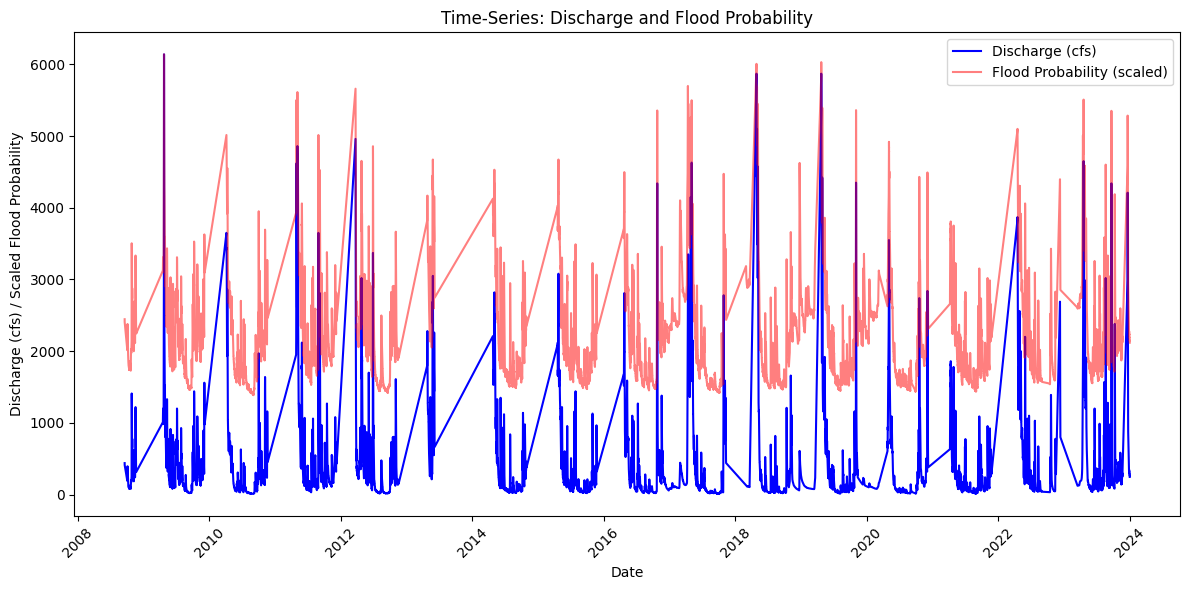

In [39]:
key_features = ['precipitation_1hr_mm', 'discharge_cfs', 'river_height_ft', 'temperature_F', 'month', 'is_monsoon',
                'lagged_discharge_1hr', 'lagged_precipitation_1hr','mean_precipitation_7d', 'mean_discharge_7d', 'Flood_probability']


plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['discharge_cfs'], label='Discharge (cfs)', color='blue')
plt.plot(df['datetime'], df['Flood_probability'] * df['discharge_cfs'].max(), label='Flood Probability (scaled)', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Discharge (cfs) / Scaled Flood Probability')
plt.title('Time-Series: Discharge and Flood Probability')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

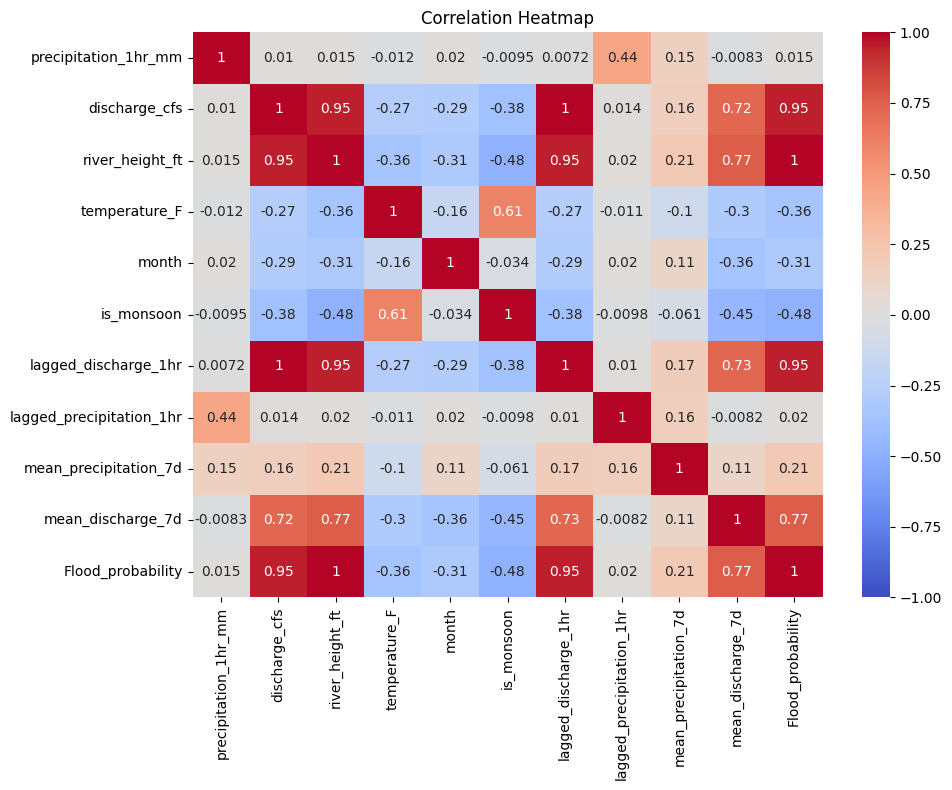

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[key_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

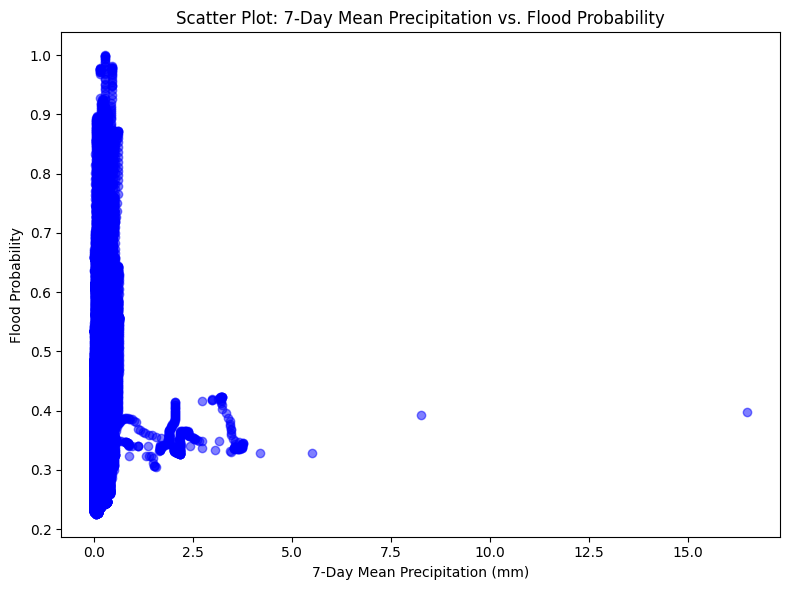

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(df['mean_precipitation_7d'], df['Flood_probability'], alpha=0.5, color='blue')
plt.xlabel('7-Day Mean Precipitation (mm)')
plt.ylabel('Flood Probability')
plt.title('Scatter Plot: 7-Day Mean Precipitation vs. Flood Probability')
plt.tight_layout()
plt.show()

# **FOR PARALLEL PROCESSING**

In [42]:
def process_chunk(chunk):
    chunk = chunk.sort_values('datetime')
    chunk['mean_precipitation_7d'] = chunk['precipitation_1hr_mm'].rolling(window=168, min_periods=1).mean()
    chunk['mean_discharge_7d'] = chunk['discharge_cfs'].rolling(window=168, min_periods=1).mean()
    return chunk

chunks = np.array_split(df, N_CORES)
with Pool(N_CORES) as p:
    results = p.map(process_chunk, chunks)
df = pd.concat(results).sort_values('datetime')

# **MODEL SECTION**

In [43]:
features = ['precipitation_1hr_mm', 'temperature_F', 'dewpoint_F', 'sea_level_pressure', 'wind_direction_deg',
            'wind_speed_mph', 'altimeter_pressure', 'relative_humidity_pct', 'wind_speed_knots', 'feels_like_F',
            'gust', 'month', 'is_monsoon', 'lagged_discharge_1hr', 'lagged_precipitation_1hr', 'mean_precipitation_7d', 'mean_discharge_7d']
target = 'Flood_risk'

In [44]:
X = df[features]
y = df[target]

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [45]:
# Function for parallelized cross-validation
def train_and_evaluate(fold_data):
    train_idx, val_idx = fold_data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Serial training
    model_serial = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=1)
    start = time.time()
    model_serial.fit(X_train, y_train)
    serial_time = time.time() - start
    y_pred_serial = model_serial.predict(X_val)
    serial_accuracy = accuracy_score(y_val, y_pred_serial)

    # Parallel training
    model_parallel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    start = time.time()
    model_parallel.fit(X_train, y_train)
    parallel_time = time.time() - start
    y_pred_parallel = model_parallel.predict(X_val)
    parallel_accuracy = accuracy_score(y_val, y_pred_parallel)

    # Prediction latency (for parallel model)
    start = time.time()
    model_parallel.predict(X_val[:1])  # Predict on single sample
    latency = time.time() - start

    return {
        'serial_accuracy': serial_accuracy,
        'parallel_accuracy': parallel_accuracy,
        'serial_time': serial_time,
        'parallel_time': parallel_time,
        'latency': latency,
        'confusion_matrix': confusion_matrix(y_val, y_pred_parallel, labels=['Low', 'Mid', 'High']),
        'classification_report': classification_report(y_val, y_pred_parallel, output_dict=True)
    }

In [46]:
# Performing K-Fold Cross-Validation
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
folds = list(kf.split(X))

start_time = time.time()
with Pool(N_CORES) as pool:
    results = pool.map(train_and_evaluate, folds)
end_time = time.time()

# Aggregating results
serial_accuracies = [result['serial_accuracy'] for result in results]
parallel_accuracies = [result['parallel_accuracy'] for result in results]
serial_times = [result['serial_time'] for result in results]
parallel_times = [result['parallel_time'] for result in results]
latencies = [result['latency'] for result in results]
confusion_matrices = [result['confusion_matrix'] for result in results]
avg_confusion_matrix = np.mean(confusion_matrices, axis=0).astype(int)

# for Printing fold results
for fold, result in enumerate(results, 1):
    print(f"\nFold {fold} Results:")
    print(f"Serial - Accuracy: {result['serial_accuracy']:.6f}, Time: {result['serial_time']:.3f}s")
    print(f"Parallel - Accuracy: {result['parallel_accuracy']:.6f}, Time: {result['parallel_time']:.3f}s")
    print(f"Prediction Latency (Parallel): {result['latency']:.6f}s")

# Print average results
print(ing"\nCross-Validation Results (Average):")
print(f"Serial - Accuracy: {np.mean(serial_accuracies):.6f}, Time: {np.mean(serial_times):.3f}s")
print(f"Parallel - Accuracy: {np.mean(parallel_accuracies):.6f}, Time: {np.mean(parallel_times):.3f}s")
print(f"Average Prediction Latency: {np.mean(latencies):.6f}s")
print(f"Total Cross-Validation Time: {end_time - start_time:.2f} seconds")



Fold 1 Results:
Serial - Accuracy: 0.985011, Time: 17.434s
Parallel - Accuracy: 0.985011, Time: 18.879s
Prediction Latency (Parallel): 0.017804s

Fold 2 Results:
Serial - Accuracy: 0.986127, Time: 17.020s
Parallel - Accuracy: 0.986127, Time: 18.300s
Prediction Latency (Parallel): 0.027180s

Fold 3 Results:
Serial - Accuracy: 0.986545, Time: 17.551s
Parallel - Accuracy: 0.986545, Time: 18.970s
Prediction Latency (Parallel): 0.021958s

Fold 4 Results:
Serial - Accuracy: 0.985290, Time: 16.495s
Parallel - Accuracy: 0.985290, Time: 16.919s
Prediction Latency (Parallel): 0.021681s

Fold 5 Results:
Serial - Accuracy: 0.986405, Time: 5.541s
Parallel - Accuracy: 0.986405, Time: 5.029s
Prediction Latency (Parallel): 0.015620s

Cross-Validation Results (Average):
Serial - Accuracy: 0.985875, Time: 14.808s
Parallel - Accuracy: 0.985875, Time: 15.619s
Average Prediction Latency: 0.020849s
Total Cross-Validation Time: 49.75 seconds


In [47]:
# Train final model on all data
model_parallel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=N_JOBS)
model_parallel.fit(X, y)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

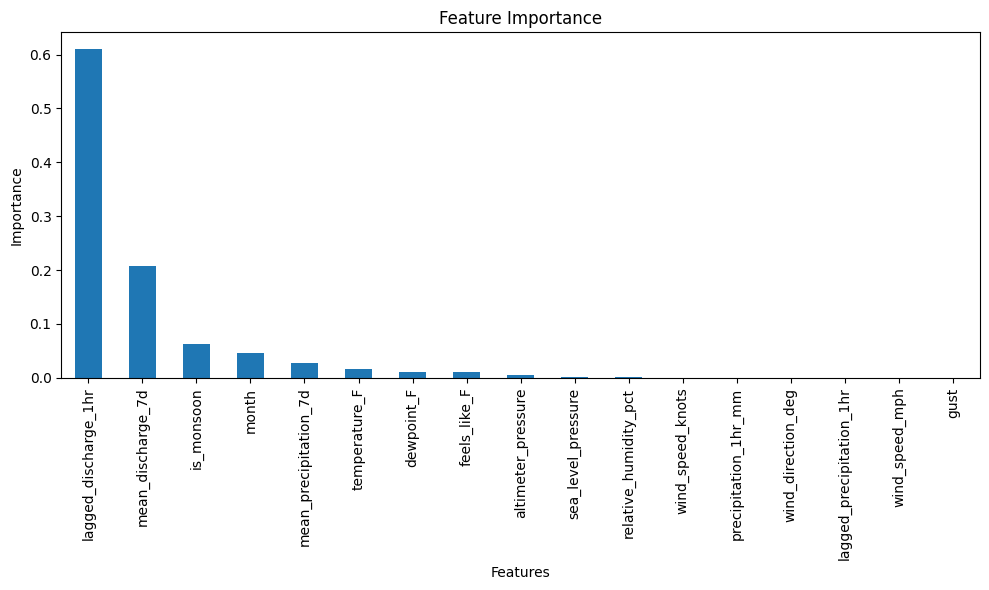

In [48]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(model_parallel.feature_importances_, index=features)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

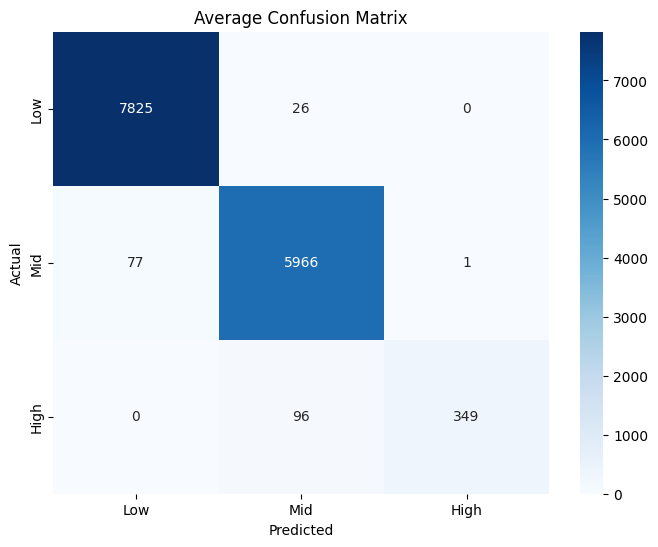

In [49]:
# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Mid', 'High'], yticklabels=['Low', 'Mid', 'High'])
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **SAMPLE INPUT FOR PREDICTION**

In [50]:
# Sample input for prediction
sample_input = {
    'precipitation_1hr_mm': 5.0, 'temperature_F': 75.0, 'dewpoint_F': 65.0, 'sea_level_pressure': 1013.0,
    'wind_direction_deg': 180.0, 'wind_speed_mph': 10.0, 'altimeter_pressure': 29.9, 'relative_humidity_pct': 80.0,
    'wind_speed_knots': 8.7, 'feels_like_F': 78.0, 'gust': 15.0, 'month': 9, 'is_monsoon': 1,
    'lagged_discharge_1hr': 500.0, 'lagged_precipitation_1hr': 4.0, 'mean_precipitation_7d': 2.5, 'mean_discharge_7d': 600.0
}

# Convert to DataFrame and predict
manual_input = pd.DataFrame([sample_input])
start = time.time()
y_pred_manual = model_parallel.predict(manual_input[features])[0]
prediction_latency = time.time() - start
y_pred_proba = model_parallel.predict_proba(manual_input[features])[0]

# Print prediction
print("\nManual Input Prediction:")
print(f"Predicted Flood Risk: {y_pred_manual}")
print(f"Prediction Latency: {prediction_latency:.6f}s")
print("Prediction Probabilities:")
for label, prob in zip(['Low', 'Mid', 'High'], y_pred_proba):
    print(f"{label}: {prob:.4f}")


Manual Input Prediction:
Predicted Flood Risk: Mid
Prediction Latency: 0.026346s
Prediction Probabilities:
Low: 0.0347
Mid: 0.0743
High: 0.8910


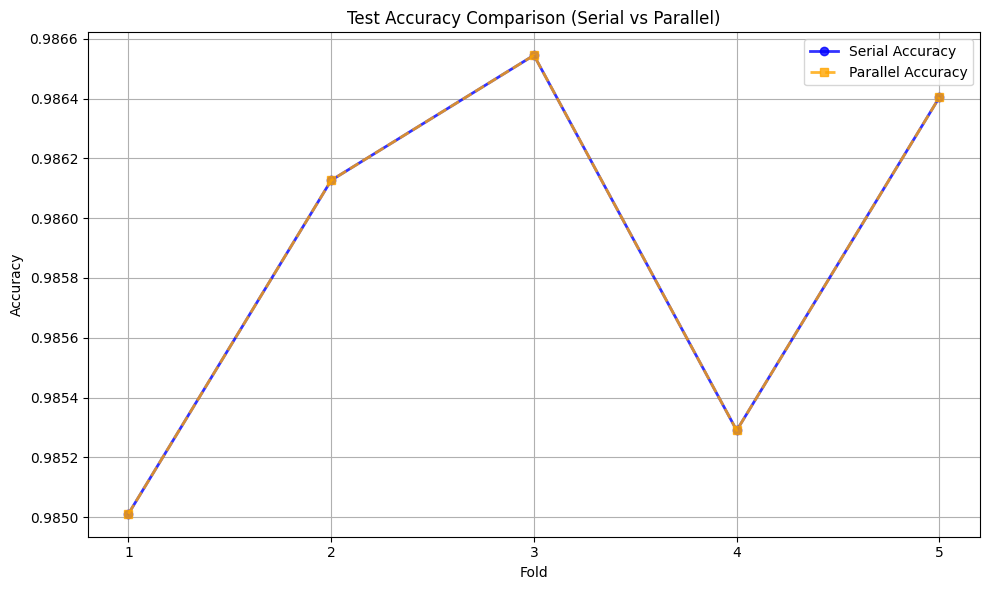

In [51]:
# Plot 1: Test Accuracy Comparison (Serial vs Parallel)
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_FOLDS + 1), serial_accuracies, marker='o', linestyle='-', linewidth=2, alpha=0.8, label='Serial Accuracy', color='blue')
plt.plot(range(1, N_FOLDS + 1), parallel_accuracies, marker='s', linestyle='--', linewidth=2, alpha=0.8, label='Parallel Accuracy', color='orange')
plt.title('Test Accuracy Comparison (Serial vs Parallel)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, N_FOLDS + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

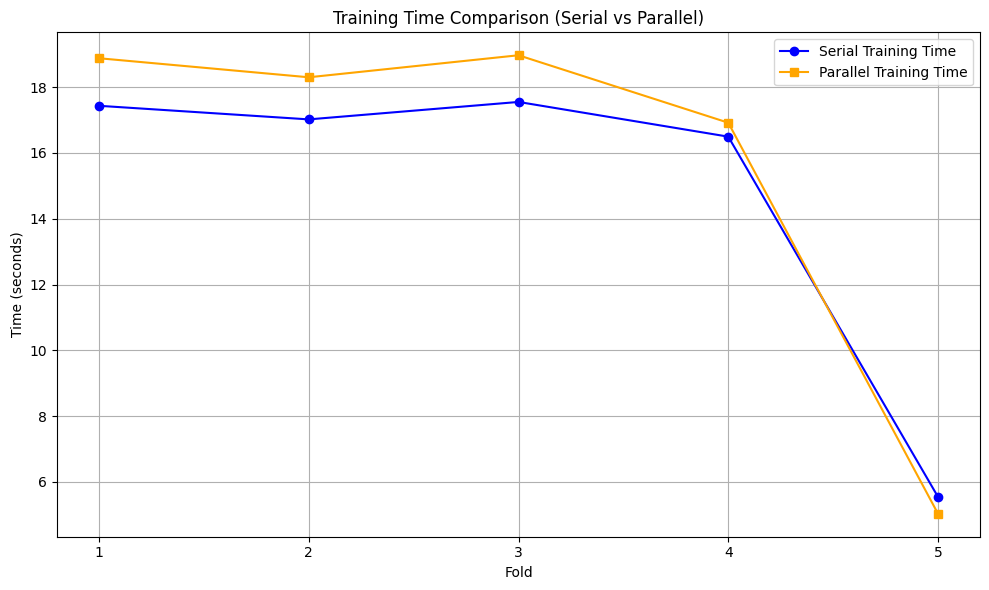

In [52]:
# Plot 2: Training Time Comparison (Serial vs Parallel)
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_FOLDS + 1), serial_times, marker='o', label='Serial Training Time', color='blue')
plt.plot(range(1, N_FOLDS + 1), parallel_times, marker='s', label='Parallel Training Time', color='orange')
plt.title('Training Time Comparison (Serial vs Parallel)')
plt.xlabel('Fold')
plt.ylabel('Time (seconds)')
plt.xticks(range(1, N_FOLDS + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

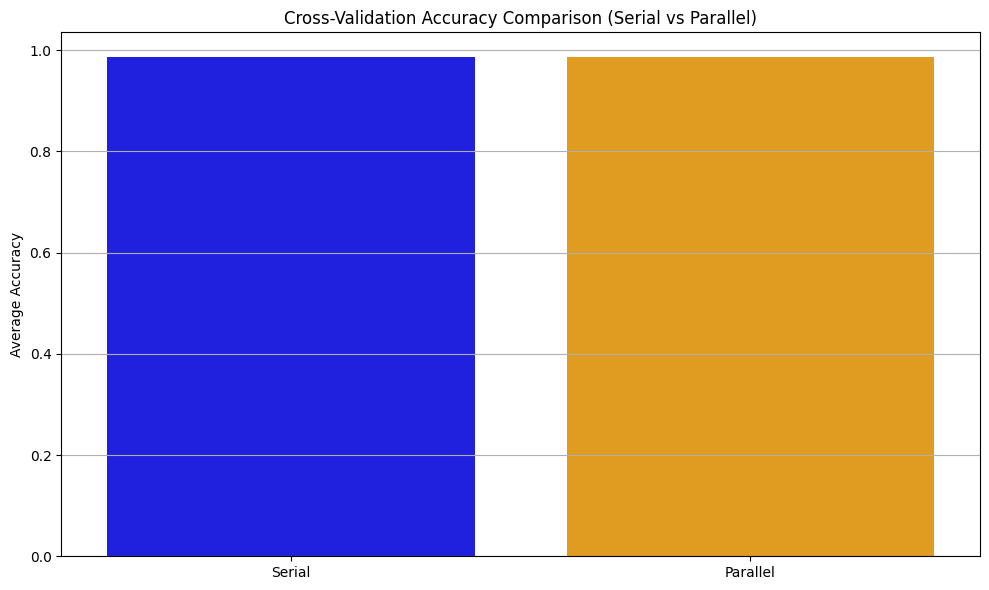

In [53]:
# Plot 3: Cross-Validation Accuracy Comparison (Serial vs Parallel)
plt.figure(figsize=(10, 6))
sns.barplot(x=['Serial', 'Parallel'], y=[np.mean(serial_accuracies), np.mean(parallel_accuracies)], palette=['blue', 'orange'])
plt.title('Cross-Validation Accuracy Comparison (Serial vs Parallel)')
plt.ylabel('Average Accuracy')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

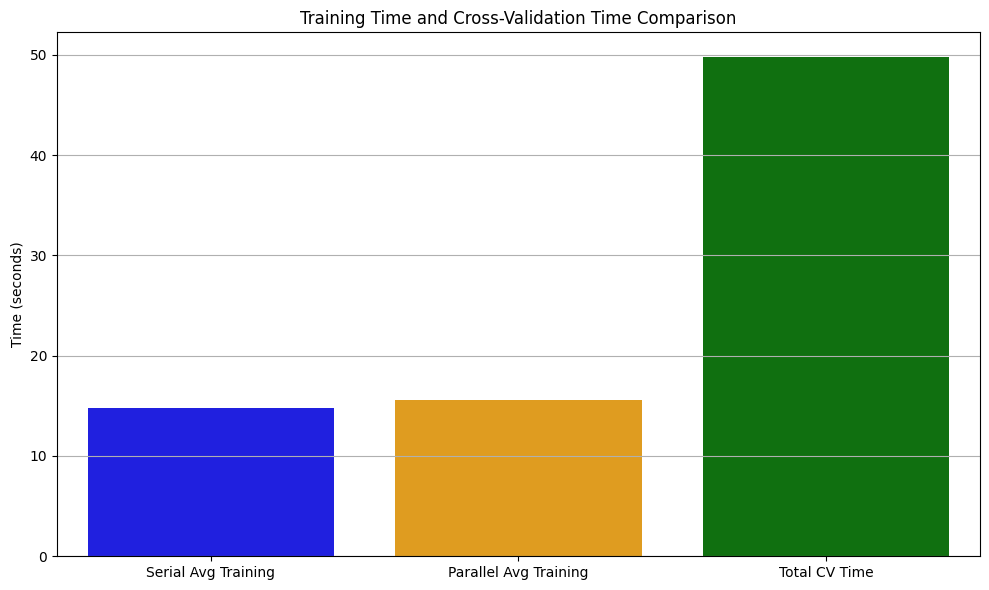

In [54]:
# Plot 4: Training Time and Cross-Validation Time Comparison (Before and After CV)
plt.figure(figsize=(10, 6))
sns.barplot(x=['Serial Avg Training', 'Parallel Avg Training', 'Total CV Time'],
            y=[np.mean(serial_times), np.mean(parallel_times), end_time - start_time],
            palette=['blue', 'orange', 'green'])
plt.title('Training Time and Cross-Validation Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()